In [ ]:
import os
from IPython.display import clear_output
from exclude_blocks import *
import joblib

from map_creation import check_world_folder_existence
import tensorflow as tf
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
#color_to_material = joblib.load('color_dicts/color_to_material.pkl')
material_to_color = joblib.load('color_dicts/material_to_color.pkl')

# CHECK WORLD NAME

In [3]:
world_name = 'main_test'
check_world_folder_existence(world_name)

True

# CHECK MCFUNCTION DIRECTORY

In [4]:
current_directory = os.getcwd()
parent = os.path.dirname(current_directory)
mcfunction_directory = os.path.join(parent,f'saves/{world_name}/datapacks/img/data/print/function')
os.path.exists(mcfunction_directory)

True

# CHOOSE IMAGE

In [5]:
image_name = 'nica.png'
image_path = f'images/{image_name}'
function_name = f"blocks_{image_name}.mcfunction"
output_path = os.path.join(mcfunction_directory, function_name)

# IMG TO MATERIAL BLOCKS

In [6]:
def load_image(image_path, channels: int, mirror_horizontal: bool = False):
    image_bytes = tf.io.read_file(image_path)
    image_tensor = tf.image.decode_image(image_bytes, channels=channels) 
    if mirror_horizontal:
        image_tensor = tf.image.flip_left_right(image_tensor)
    int_image = tf.cast(image_tensor, dtype=tf.int32)
    return int_image

In [7]:
def resize(image_tensor, new_height, new_width):
    resized_image = tf.image.resize(image_tensor, ((new_height, new_width)))
    resized_image = tf.cast(resized_image, dtype=tf.int32)
    return resized_image
def assert_new_proportion(image_tensor):
    current_size = image_tensor.shape[:2]
    new_size = False
    while True:
        if not new_size:
            is_this_ok = input(f'Is this ok: X:{current_size[0]}, Y: {current_size[1]}')
        else:
            is_this_ok = input(f'Is this ok: X:{new_size[0]}, Y: {new_size[1]}   ')
        if is_this_ok != 'yes':
            new_proportion = input('ok, new scale then: ')
            try:
                new_proportion = float(new_proportion)
            except:
                print(new_proportion, 'must be a float number, eg 0.2')
                continue
            new_size = [np.ceil(side * float(new_proportion)) for side in current_size]
            print(new_size)
        else:
            if new_size:
                image_tensor = resize(image_tensor, int(new_size[0]), int(new_size[1]))
                return image_tensor, [int(x) for x in new_size]
            else:
                image_tensor = resize(image_tensor, current_size[0], current_size[1])
                return image_tensor, [int(x) for x in current_size]



def filter_block_from_model(material_to_color):
    available_materials = list(material_to_color.keys())
    available_materials = [x.replace('.png','') for x in material_to_color.keys()]
    
    filtered_material_to_color = dict()
    for material in available_materials:
        if material in allowed_blocks:
            filtered_material_to_color[material] = material_to_color[material+'.png']
    filtered_color_to_material = dict(zip(filtered_material_to_color.values(),
                                         filtered_material_to_color.keys()))
    return filtered_material_to_color, filtered_color_to_material
    
    # filtered_color_to_material = dict(zip(material_to_color.values(),
    #                                      [x.replace('.png','') for x in material_to_color.keys()]))
    # return material_to_color, filtered_color_to_material
    
            
def get_image_to_blocks_color_model(filtered_material_to_color):
    available_colors = list(filtered_material_to_color.values())
    colors = np.array(available_colors)
    color_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
    color_model.fit(colors)
    return color_model, colors
def get_block_from_rgb_array(image_tensor):
    import random
    x = image_tensor.shape[0]
    y = image_tensor.shape[1]
    
    filtered_material_to_color, filtered_color_to_material = filter_block_from_model(material_to_color)    
    color_model, colors = get_image_to_blocks_color_model(filtered_material_to_color)
    for_prediction = tf.reshape(image_tensor, [x*y, 3])
    # probabilities = [0.75, 0.15, 0.1]
    dist, prediction = color_model.kneighbors(for_prediction)
    prediction = [colors[x] for x in prediction]
    blocks = [filtered_color_to_material[tuple(prediction[x][0])] for x,y in enumerate(prediction)]
    
    return blocks

In [8]:
image_tensor = load_image(image_path, channels=3, mirror_horizontal= False)

I0000 00:00:1749957570.867642    3627 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1749957570.872217    3627 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6717 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:03:00.0, compute capability: 6.1


In [9]:
image_tensor.shape

TensorShape([301, 640, 3])

In [10]:
image_tensor, new_size = assert_new_proportion(image_tensor)

Is this ok: X:301, Y: 640 n
ok, new scale then:  0.2


[61.0, 128.0]


Is this ok: X:61.0, Y: 128.0    yes


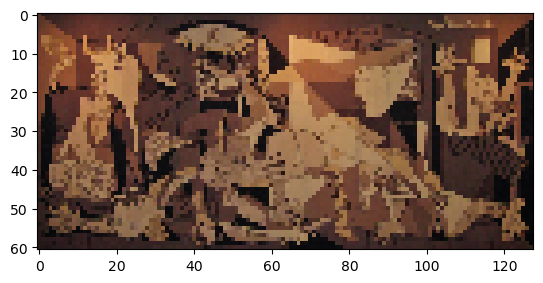

In [11]:
plt.imshow(image_tensor)

In [12]:
image_tensor.shape

TensorShape([61, 128, 3])

In [13]:
blocks = get_block_from_rgb_array(image_tensor)

In [14]:
len(blocks)

7808

# MCFUNCTION CREATION

### Create Function Lines

In [15]:
def setblock(x,y,z,material):
    return f"setblock ~{x} ~{y} ~{z} {material}" +"\n"

In [16]:
def write_blocks_all_facing_directions(blocks,image_name, new_size):
    
    for facing in ['floor', 'wall']:
        
        output = f"{mcfunction_directory}/blocks_{image_name.split('.')[0]}_{facing}_{new_size[0]}_{new_size[1]}.mcfunction"
        current_block = 0
        mcfunction_lines = []
        for columns in range(new_size[0]):
            for rows in range(new_size[1]):
                if facing == 'floor':
                    mcfunction_lines.append(setblock(columns,0,rows,blocks[current_block]))
                else:
                    mcfunction_lines.append(setblock(columns,rows,0,blocks[current_block]))
                current_block +=1
        with open(output, "w") as f:
            for line in mcfunction_lines:
                f.write(line)

In [17]:
write_blocks_all_facing_directions(blocks,image_name, new_size)

In [42]:
available_materials = list(material_to_color.keys())
available_materials = [x.replace('.png','') for x in material_to_color.keys()]

In [46]:
excluded_blocks = [x.replace('.png','') for x in excluded_blocks]

In [48]:
excluded_blocks

['test_block_log',
 'crafter_north_crafting',
 'cauldron_inner',
 'grass_block_snow',
 'pointed_dripstone_down_base',
 'creaking_heart_awake',
 'magma']

In [49]:
excluded_blocks[0]

'test_block_log'

In [76]:
'jigsaw_lock' in available_materials

True

In [ ]:
mcfunction_lines

In [ ]:
mcfunction_directory

'/mnt/c/Users/bolap/AppData/Roaming/.minecraft/saves/main_test/datapacks/img/data/print/function/blocks_stair_36_55.mcfunction'

In [35]:
output_path

'/mnt/c/Users/bolap/AppData/Roaming/.minecraft/saves/main_test/datapacks/img/data/print/function/blocks_stair.png.mcfunction'

In [15]:
len(for_prediction)

1980

In [16]:
image_tensor.shape[0] *image_tensor.shape[1] 

1980

In [41]:
# available_materials = list(material_to_color.keys())
    # available_materials = [x for x in available_materials if "terracotta" in x]
    
    # filtered_material_to_color = dict()
    # for material in available_materials:
    #     filtered_material_to_color[material[:-4]] = material_to_color[material]
    # filtered_color_to_material = dict(zip(filtered_material_to_color.values(),
    #                                      filtered_material_to_color.keys()))
    # return filtered_material_to_color, filtered_color_to_material